In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
from networkx import DiGraph
from networkx.algorithms import centrality, cluster

import random
import os, sys
import math

from tensorflow.python.ops.rnn import _transpose_batch_time
from sklearn.model_selection import train_test_split

#performance metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

import scipy.stats as stats
from scipy.stats import chisquare
from scikit_posthocs import posthoc_dunn
import statistics
#user defined
from utils_log import save_logging, load_logging
from data_loader import import_data
from class_AC_TPC import AC_TPC, initialize_embedding



In [2]:
def f_get_minibatch(mb_size, x, y):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb   = x[idx].astype(float)    
    y_mb   = y[idx].astype(float)    

    return x_mb, y_mb

### PERFORMANCE METRICS:
def f_get_prediction_scores(y_true_, y_pred_):
    if np.sum(y_true_) == 0: #no label for running roc_auc_curves
        auroc_ = -1.
        auprc_ = -1.
    else:
        auroc_ = roc_auc_score(y_true_, y_pred_)
        auprc_ = average_precision_score(y_true_, y_pred_)
    return (auroc_, auprc_)


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    c_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(c_matrix, axis=0)) / np.sum(c_matrix)

# IMPORT DATASET

In [3]:
# Imported data in form of graph embedding vectors stored in .npy file
patientData = np.load('PatientData.npy', allow_pickle = True)
patientData

array([list([[array([-0.03933552,  0.10056045, -0.11232913,  0.23483431,  0.26212722,
        0.15907377,  0.19913995,  0.20983027,  0.05224806], dtype=float32), [0, 1, 0], 3], [array([-0.04931673,  0.02645371, -0.1100987 ,  0.2725991 ,  0.33798212,
        0.12997887,  0.25053194,  0.20711672,  0.03513897], dtype=float32), [0, 1, 0], 6], [array([-0.04421705,  0.0897153 , -0.11542875,  0.25209045,  0.2895582 ,
        0.13037293,  0.24260753,  0.14878133,  0.08550232], dtype=float32), [0, 1, 0], 12], [array([-0.05416958, -0.00407126, -0.10644492,  0.35461736,  0.4190165 ,
        0.01533044,  0.35767692,  0.11566763,  0.10353107], dtype=float32), [0, 1, 0], 36], [array([-0.04186276,  0.11843274, -0.12038249,  0.22824039,  0.24371755,
        0.16769329,  0.18542133,  0.19660452,  0.04335345], dtype=float32), [0, 1, 0], 48]]),
       list([[array([-0.06509169,  0.09054915, -0.13036482,  0.26122454,  0.31561   ,
        0.06889939,  0.300625  ,  0.0770558 ,  0.1703    ], dtype=float32), 

In [4]:
patientIndexes = np.load('4VisitPatientIDs.npy')

In [5]:
# Collecting sets of 4 time points
patientList4Vis = []
for k in range(141):
  if len(patientData[k]) >= 4:
      patientList4Vis.append(patientData[k][:2] + patientData[k][len(patientData[k]) - 2:])

patientList4Vis = np.asarray(patientList4Vis)

labels = []
for i in patientList4Vis:
    label = []
    for j in range(len(i)):
        label.append(i[j][1])
    labels.append(label)  
labels = np.asarray(labels)

#Characteristic Label for enhanced stratification
characteristicLabels = []
for patient in patientList4Vis:
  zeroCounter = 0
  oneCounter = 0
  for i in range(4):
    if patient[i][1][1] == 0:
      zeroCounter+=1
    else:
      oneCounter+=1
        
  if oneCounter > zeroCounter:
    characteristicLabels.append(1)
  else:
    characteristicLabels.append(0)

In [7]:
patientData4Visits = patientList4Vis

In [242]:
males = []
females = []
for i in range(len(patientIndexes)):
    patientID = patientIndexes[i]
    
    for j in range(4):
        visCode = patientData4Visits[i][j][2]

        gender = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["PTGENDER"].values[0] 

        if gender == 'Male':
            males.append([patientID,visCode])
        else:
            females.append([patientID,visCode])


In [243]:
males

[[141, 3],
 [141, 6],
 [141, 36],
 [141, 48],
 [27, 0],
 [27, 3],
 [27, 24],
 [27, 36],
 [66, 0],
 [66, 3],
 [66, 36],
 [66, 48],
 [127, 0],
 [127, 3],
 [127, 24],
 [127, 36],
 [140, 0],
 [140, 3],
 [140, 24],
 [140, 36],
 [126, 0],
 [126, 6],
 [126, 36],
 [126, 48],
 [53, 0],
 [53, 3],
 [53, 12],
 [53, 48],
 [137, 0],
 [137, 3],
 [137, 12],
 [137, 24],
 [144, 0],
 [144, 6],
 [144, 24],
 [144, 48],
 [20, 6],
 [20, 12],
 [20, 24],
 [20, 48],
 [114, 0],
 [114, 3],
 [114, 24],
 [114, 36],
 [31, 0],
 [31, 3],
 [31, 24],
 [31, 48],
 [77, 3],
 [77, 6],
 [77, 12],
 [77, 24],
 [149, 0],
 [149, 3],
 [149, 12],
 [149, 24],
 [110, 3],
 [110, 6],
 [110, 24],
 [110, 48],
 [43, 0],
 [43, 3],
 [43, 6],
 [43, 24],
 [85, 0],
 [85, 3],
 [85, 12],
 [85, 24],
 [18, 3],
 [18, 6],
 [18, 24],
 [18, 48],
 [21, 0],
 [21, 3],
 [21, 24],
 [21, 48],
 [84, 0],
 [84, 3],
 [84, 12],
 [84, 24],
 [73, 0],
 [73, 3],
 [73, 12],
 [73, 24],
 [10, 0],
 [10, 3],
 [10, 6],
 [10, 12],
 [145, 0],
 [145, 3],
 [145, 6],
 [145, 1

In [233]:
male = []
for i in males:
    age = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == i[0]) & (cortical_thickness["VISCODE"] == i[1])]["DX"].values[0] 
    male.append(age)

In [234]:
female = []
for i in females:
    age = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == i[0]) & (cortical_thickness["VISCODE"] == i[1])]["DX"].values[0] 
    female.append(age)

In [230]:
from statistics import mean
allAges = maleAges + ages

In [240]:
cnCount = 0
mciCount = 0
adCount = 0

for i in female:
    if i == 'CN':
        cnCount += 1
    elif i == 'EMCI' or i == 'LMCI':
        mciCount += 1
    else:
        adCount += 1
        

In [241]:
print(cnCount, mciCount, adCount)

8 17 5


In [48]:
cortical_thickness = pd.read_csv('Cortical_Thickness.csv')
clinical_score = pd.read_csv('data2.csv')

scores = clinical_score.iloc[:,24:47]
scores = pd.DataFrame(scores)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
rescaledX=scaler.fit_transform(scores)
np.set_printoptions(precision=3) #Setting precision for the output
scores = rescaledX
scores = pd.DataFrame(scores)
scores.columns = ['RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','LDELTOTAL','DIGITSCOR','TRABSCOR','FAQ','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']

header = clinical_score.iloc[:,:15]
scores = pd.concat([header,scores], axis = 1)

labels = [] 

for i in range(len(patientData4Visits)):
    patient = []
    patientIndex = patientIndexes[i]
    for j in range(4):
        visit = []
        visCode = patientData4Visits[i][j][2]
        scanIndex = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientIndex) & (cortical_thickness["VISCODE"] == visCode)]["SCANINDEX"].values[0]
        #columns = ['RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'EcogPtMem_bl', 'mPACCdigit_bl', 'mPACCtrailsB_bl','EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPTotal_bl']
        columns = ['EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']
        for index in range(14):
            a = scores.loc[(clinical_score["subject"] == scanIndex)][columns[index]].values[0]
            visit.append(a)
        patient.append(visit)
    labels.append(patient)
        
        

C:\Users\andre\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\andre\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [49]:
labels

[[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  [0.5714300000000001,
   0.39130366729796995,
   0.33333203703775727,
   0.28571428571428575,
   0.14117663667839603,
   nan,
   0.36170158895508026,
   0.7083333333333333,
   0.5555566666666667,
   0.5238099999999999,
   0.26666666666666666,
   0.0,
   0.08333333333333331,
   0.4137932193816486],
  [0.2916666666666667,
   0.14673887523673868,
   0.33333203703775727,
   0.0714285714285714,
   0.3529415916959902,
   0.24999999999999994,
   0.24439452962516856,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  [0.4166666666666667,
   0.3478259168244926,
   0.23333320370377575,
   0.0714285714285714,
   0.2647061937719926,
   0.22222333333333338,
   0.28723446582100837,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]],
 [[0.7083333333333333,
   0.7391295841224625,
   0.6111113271603736,
   0.49999999999999994,
   0.3529415916959902,
   0.5833333333333333,
   0.6028371872637637,
   0.208333333333333

In [55]:
import sys
np.set_printoptions(threshold = sys.maxsize)

labels = np.asarray(labels)
labels = np.reshape(labels, [69, 4, 14])
data_y = labels
data_y

array([[[0.571, 0.391, 0.333, 0.286, 0.141, 0.25 , 0.362, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414],
        [0.432, 0.269, 0.333, 0.179, 0.247, 0.25 , 0.303, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414],
        [0.292, 0.147, 0.333, 0.071, 0.353, 0.25 , 0.244, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414],
        [0.417, 0.348, 0.233, 0.071, 0.265, 0.222, 0.287, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414]],

       [[0.708, 0.739, 0.611, 0.5  , 0.353, 0.583, 0.603, 0.208, 0.148,
         0.143, 0.133, 0.   , 0.333, 0.155],
        [0.625, 0.63 , 0.472, 0.357, 0.206, 0.458, 0.482, 0.271, 0.241,
         0.205, 0.067, 0.   , 0.333, 0.196],
        [0.542, 0.522, 0.333, 0.214, 0.059, 0.333, 0.362, 0.333, 0.333,
         0.267, 0.   , 0.   , 0.333, 0.237],
        [0.333, 0.391, 0.389, 0.357, 0.353, 0.333, 0.362, 0.25 , 0.296,
         0.333, 0.2  , 0.   , 0.333, 0.241]],

       [[0.292, 0.087, 0.056, 0.071, 0.176, 0.   , 0.13 , 0.

In [51]:
# obtain edge visits
for i in range(len(data_y)):
    if math.isnan(data_y[i][0][0]) and math.isnan(data_y[i][0][5]) and math.isnan(data_y[i][0][12]):
         data_y[i][0] = data_y[i][1]

for i in range(len(data_y)):
    if math.isnan(data_y[i][3][0]) and math.isnan(data_y[i][3][5]) and math.isnan(data_y[i][3][4]) and math.isnan(data_y[i][3][10]):
         data_y[i][0] = data_y[i][1]

In [52]:
# Averaging to obtain middle visits
for i in range(len(data_y)):
    for j in range(4):
        if j == 1 or j == 2 and math.isnan(data_y[i][j][0]) and math.isnan(data_y[i][j][5]) and math.isnan(data_y[i][j][4]) and math.isnan(data_y[i][j][10]):
            average = (data_y[i][j-1] + data_y[i][j+1])/2.0
            data_y[i][j] = average

In [53]:
# Individual nan values matched to closest existing
for i in range(len(data_y)):
    for k in range(14):
        scores = []
        notnan = []
        for j in range(4):   
            scores.append(data_y[i][j][k])
        for l in range(4):
            if not math.isnan(scores[l]):
                notnan.append(l)
        for p in range(4):
            if math.isnan(scores[p]):
                mindiff = 10
                minindex = 0
                for h in notnan:
                    if abs(h-p) < mindiff:
                        mindiff = abs(h - p)
                        minindex = h
                data_y[i][p][k] = data_y[i][minindex][k]
                
                

In [54]:
data_y

array([[[0.571, 0.391, 0.333, 0.286, 0.141, 0.25 , 0.362, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414],
        [0.432, 0.269, 0.333, 0.179, 0.247, 0.25 , 0.303, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414],
        [0.292, 0.147, 0.333, 0.071, 0.353, 0.25 , 0.244, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414],
        [0.417, 0.348, 0.233, 0.071, 0.265, 0.222, 0.287, 0.708, 0.556,
         0.524, 0.267, 0.   , 0.083, 0.414]],

       [[0.708, 0.739, 0.611, 0.5  , 0.353, 0.583, 0.603, 0.208, 0.148,
         0.143, 0.133, 0.   , 0.333, 0.155],
        [0.625, 0.63 , 0.472, 0.357, 0.206, 0.458, 0.482, 0.271, 0.241,
         0.205, 0.067, 0.   , 0.333, 0.196],
        [0.542, 0.522, 0.333, 0.214, 0.059, 0.333, 0.362, 0.333, 0.333,
         0.267, 0.   , 0.   , 0.333, 0.237],
        [0.333, 0.391, 0.389, 0.357, 0.353, 0.333, 0.362, 0.25 , 0.296,
         0.333, 0.2  , 0.   , 0.333, 0.241]],

       [[0.292, 0.087, 0.056, 0.071, 0.176, 0.   , 0.13 , 0.

In [14]:
# One example of 4 nan values all 4 visits
for i in range(len(data_y)):
    for j in range(4):
        for k in range(14):
            if math.isnan(data_y[i][j][k]):
                data_y[i][j][k] = 0.5

In [15]:
np.save('neurologicalScores', data_y)

In [16]:
# Data preparation for 4 visits

data_x = []
#data_y = []

for i in patientData4Visits:
    patientArray = []
    patientLabels = []
    for j in range(len(i)):
        if j == 0:
            timeDiff = 0
        else:
            timeDiff = i[j][2] - i[j-1][2]
          
        featureArray = np.insert(i[j][0], 0, 0.5)
        #featureArray = np.insert(i[j][0], 0, timeDiff)
        patientArray.append(featureArray)
        patientLabels.append(i[j][1])
    patientArray = np.asarray(patientArray)
    patientLabels = np.asarray(patientLabels)
    data_x.append(patientArray)
    #data_y.append(patientLabels)    

In [17]:
data_x

[array([[ 0.5  , -0.039,  0.101, -0.112,  0.235,  0.262,  0.159,  0.199,
          0.21 ,  0.052],
        [ 0.5  , -0.049,  0.026, -0.11 ,  0.273,  0.338,  0.13 ,  0.251,
          0.207,  0.035],
        [ 0.5  , -0.054, -0.004, -0.106,  0.355,  0.419,  0.015,  0.358,
          0.116,  0.104],
        [ 0.5  , -0.042,  0.118, -0.12 ,  0.228,  0.244,  0.168,  0.185,
          0.197,  0.043]], dtype=float32),
 array([[ 5.000e-01, -1.015e-01,  1.079e-01, -1.599e-01,  3.434e-01,
          3.510e-01, -1.256e-02,  4.193e-01, -1.085e-02,  3.611e-01],
        [ 5.000e-01, -9.880e-02,  4.643e-02, -1.481e-01,  3.858e-01,
          4.168e-01, -1.955e-02,  4.483e-01, -1.139e-02,  3.511e-01],
        [ 5.000e-01, -8.268e-02,  1.764e-01, -1.550e-01,  2.586e-01,
          2.443e-01,  5.253e-02,  2.880e-01,  3.392e-02,  2.855e-01],
        [ 5.000e-01, -8.826e-02,  5.790e-02, -1.452e-01,  3.516e-01,
          3.991e-01, -7.239e-03,  4.142e-01, -2.728e-04,  2.725e-01]],
       dtype=float32),
 array(

In [18]:
'''
# Data preparation for all data, 0s for nonexistent points
data_x = []
data_y = []

for i in patientData:
    patientArray = []
    patientLabels = []
    for j in range(len(i)):
        if j == 0:
            timeDiff = 0
        else:
            timeDiff = i[j][2] - i[j-1][2]
           
        featureArray = np.insert(i[j][0], 0, 0.5)
        #featureArray = np.insert(i[j][0], 0, timeDiff)
        patientArray.append(featureArray)
        patientLabels.append(i[j][1])
        
    
    if len(i) < 7:
        N = 7 - len(i)
        zeros = [0,0,0,0,0,0,0,0,0,0]
        zeros2 = [0,0,0]
        for i in range(N):
            patientArray.append(zeros)
            patientLabels.append(zeros2)
    
    patientArray = np.asarray(patientArray)
    patientLabels = np.asarray(patientLabels)
    data_x.append(patientArray)
    data_y.append(patientLabels)  
'''

'\n# Data preparation for all data, 0s for nonexistent points\ndata_x = []\ndata_y = []\n\nfor i in patientData:\n    patientArray = []\n    patientLabels = []\n    for j in range(len(i)):\n        if j == 0:\n            timeDiff = 0\n        else:\n            timeDiff = i[j][2] - i[j-1][2]\n           \n        featureArray = np.insert(i[j][0], 0, 0.5)\n        #featureArray = np.insert(i[j][0], 0, timeDiff)\n        patientArray.append(featureArray)\n        patientLabels.append(i[j][1])\n        \n    \n    if len(i) < 7:\n        N = 7 - len(i)\n        zeros = [0,0,0,0,0,0,0,0,0,0]\n        zeros2 = [0,0,0]\n        for i in range(N):\n            patientArray.append(zeros)\n            patientLabels.append(zeros2)\n    \n    patientArray = np.asarray(patientArray)\n    patientLabels = np.asarray(patientLabels)\n    data_x.append(patientArray)\n    data_y.append(patientLabels)  \n'

In [19]:
data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
y_type = 'continuous'
#data_x, data_y, y_type = import_data(data_name = 'sample')

In [20]:
seed = 1234

tr_data_x,te_data_x, tr_data_y,te_data_y = train_test_split(
    data_x, data_y, test_size=0.2, random_state=seed
)

tr_data_x,va_data_x, tr_data_y,va_data_y = train_test_split(
    tr_data_x, tr_data_y, test_size=0.2, random_state=seed
)

# DEFINE NETWORK PARAMETERS

In [21]:
K = 5

h_dim_FC   = 26 #for fully_connected layers
h_dim_RNN  = 26

x_dim = np.shape(data_x)[2]
y_dim = np.shape(data_y)[2]
  
    
num_layer_encoder    = 2
num_layer_selector   = 3
num_layer_predictor  = 2

z_dim = h_dim_RNN * num_layer_encoder

max_length = np.shape(data_x)[1]

rnn_type          = 'LSTM' #GRU, LSTM


input_dims ={
    'x_dim': x_dim,
    'y_dim': y_dim,
    'y_type': y_type,
    'max_cluster': K,
    'max_length': max_length    
}

network_settings ={
    'h_dim_encoder': h_dim_RNN,
    'num_layers_encoder': num_layer_encoder,
    'rnn_type': rnn_type,
    'rnn_activate_fn': tf.nn.tanh,

    'h_dim_selector': h_dim_FC,
    'num_layers_selector': num_layer_selector,
    
    'h_dim_predictor': h_dim_FC,
    'num_layers_predictor': num_layer_predictor,
    
    'fc_activate_fn': tf.nn.relu
}

# TRAIN -- INITIALIZE NETWORK

In [22]:
lr_rate    = 0.0001
keep_prob  = 0.5
mb_size    = 32
data_name = '3'

ITERATION  = 3750
check_step = 250

save_path = './{}/proposed/init/'.format(data_name)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

In [23]:
print('Initialize Network...')

tf.reset_default_graph()

# Turn on xla optimization
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = AC_TPC(sess, "AC_TPC", input_dims, network_settings)


saver = tf.train.Saver()
sess.run(tf.global_variables_initializer(), feed_dict={model.E:np.zeros([K, z_dim]).astype(float)})

avg_loss  = 0
for itr in range(ITERATION):
    x_mb, y_mb  = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

    _, tmp_loss = model.train_mle(x_mb, y_mb, lr_rate, keep_prob)
    avg_loss   += tmp_loss/check_step

    if (itr+1)%check_step == 0:                
        tmp_y, tmp_m = model.predict_y_hats(va_data_x)

        y_pred = tmp_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]
        y_true = va_data_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]
        val_loss = np.sum((y_true - y_pred)**2, axis=-1)
        avg_val_loss = np.mean(val_loss)
        
        print ("ITR {:05d}: loss_train={:.3f} loss_val={:.3f}".format(
                itr+1, avg_loss, avg_val_loss)
              )   
        avg_loss = 0

saver.save(sess, save_path + 'models/model_K{}'.format(K))
save_logging(network_settings, save_path + 'models/network_settings_K{}.txt'.format(K))

Initialize Network...



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be

# TRAIN -- TEMPORAL PHENOTYPING

In [24]:
alpha  = 0.00001
beta   = 1

mb_size    = 8
M          = int(tr_data_x.shape[0]/mb_size) #for main algorithm
keep_prob  = 0.7
lr_rate1   = 0.0001
lr_rate2   = 0.0001

save_path = './{}/proposed/trained/'.format(data_name)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

if not os.path.exists(save_path + '/results/'):
    os.makedirs(save_path + '/results/')

In [25]:
### LOAD INITIALIZED NETWORK

load_path = './{}/proposed/init/'.format(data_name)

tf.reset_default_graph()

# Turn on xla optimization
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

network_settings = load_logging(load_path + 'models/network_settings_K{}.txt'.format(K))
z_dim = network_settings['num_layers_encoder'] * network_settings['h_dim_encoder']

model = AC_TPC(sess, "AC_TPC", input_dims, network_settings)

saver = tf.train.Saver()
saver.restore(sess, load_path + 'models/model_K{}'.format(K))

INFO:tensorflow:Restoring parameters from ./3/proposed/init/models/model_K5


In [26]:
print('=============================================')
print('===== INITIALIZING EMBEDDING & SELECTOR =====')
# K-means over the latent encodings
e, s_init, tmp_z = initialize_embedding(model, tr_data_x, K)
e = np.arctanh(e)
sess.run(model.EE.initializer, feed_dict={model.E:e}) #model.EE = tf.nn.tanh(model.E)

# update selector wrt initial classes
ITERATION  = 15000
check_step = 1000

avg_loss_s = 0
for itr in range(ITERATION):
    z_mb, s_mb = f_get_minibatch(mb_size, tmp_z, s_init)
    _, tmp_loss_s = model.train_selector(z_mb, s_mb, lr_rate1, k_prob=keep_prob)

    avg_loss_s += tmp_loss_s/check_step
    if (itr+1)%check_step == 0:
        print("ITR:{:04d} | Loss_s:{:.4f}".format(itr+1, avg_loss_s) )
        avg_loss_s = 0

tmp_ybars = model.predict_yy(np.tanh(e))
new_e     = np.copy(e)
print('=============================================')

===== INITIALIZING EMBEDDING & SELECTOR =====
ITR:1000 | Loss_s:1.5428
ITR:2000 | Loss_s:1.2993
ITR:3000 | Loss_s:1.0662
ITR:4000 | Loss_s:0.9039
ITR:5000 | Loss_s:0.8251
ITR:6000 | Loss_s:0.7461
ITR:7000 | Loss_s:0.6918
ITR:8000 | Loss_s:0.6392
ITR:9000 | Loss_s:0.5976
ITR:10000 | Loss_s:0.5742
ITR:11000 | Loss_s:0.5594
ITR:12000 | Loss_s:0.5273
ITR:13000 | Loss_s:0.5104
ITR:14000 | Loss_s:0.4884
ITR:15000 | Loss_s:0.4744


In [27]:
print('=============================================')
print('========== TRAINING MAIN ALGORITHM ==========')
'''
    L1: predictive clustering loss
    L2: sample-wise entropy loss
    L3: embedding separation loss
'''

ITERATION     = 5000
check_step    = 100

avg_loss_c_L1 = 0
avg_loss_a_L1 = 0
avg_loss_a_L2 = 0
avg_loss_e_L1 = 0 
avg_loss_e_L3 = 0

va_avg_loss_L1 = 0
va_avg_loss_L2 = 0
va_avg_loss_L3 = 0

for itr in range(ITERATION):        
    e = np.copy(new_e)

    for _ in range(M):
        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

        _, tmp_loss_c_L1  = model.train_critic(x_mb, y_mb, lr_rate1, keep_prob)
        avg_loss_c_L1    += tmp_loss_c_L1/(M*check_step)

        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

        _, tmp_loss_a_L1, tmp_loss_a_L2 = model.train_actor(x_mb, y_mb, alpha, lr_rate2, keep_prob)
        avg_loss_a_L1 += tmp_loss_a_L1/(M*check_step)
        avg_loss_a_L2 += tmp_loss_a_L2/(M*check_step)
        
    for _ in range(M):
        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

        _, tmp_loss_e_L1, tmp_loss_e_L3 = model.train_embedding(x_mb, y_mb, beta, lr_rate1, keep_prob)
        avg_loss_e_L1  += tmp_loss_e_L1/(M*check_step)
        avg_loss_e_L3  += tmp_loss_e_L3/(M*check_step)

        
    x_mb, y_mb = f_get_minibatch(mb_size, va_data_x, va_data_y)
    tmp_loss_L1, tmp_loss_L2, tmp_loss_L3 = model.get_losses(x_mb, y_mb)
    
    va_avg_loss_L1  += tmp_loss_L1/check_step
    va_avg_loss_L2  += tmp_loss_L2/check_step
    va_avg_loss_L3  += tmp_loss_L3/check_step

    new_e = sess.run(model.embeddings)

    if (itr+1)%check_step == 0:
        tmp_ybars = model.predict_yy(new_e)
        print ("ITR {:04d}: L1_c={:.3f}  L1_a={:.3f}  L1_e={:.3f}  L2={:.3f}  L3={:.3f} || va_L1={:.3f}  va_L2={:.3f}  va_L3={:.3f}".format(
            itr+1, avg_loss_c_L1, avg_loss_a_L1, avg_loss_e_L1, avg_loss_a_L2, avg_loss_e_L3,
            va_avg_loss_L1, va_avg_loss_L2, va_avg_loss_L3
        ))
        avg_loss_c_L1 = 0
        avg_loss_a_L1 = 0
        avg_loss_a_L2 = 0
        avg_loss_e_L1 = 0
        avg_loss_e_L3 = 0
        va_avg_loss_L1 = 0
        va_avg_loss_L2 = 0
        va_avg_loss_L3 = 0
print('=============================================')




========== TRAINING MAIN ALGORITHM ==========
ITR 0100: L1_c=3.255  L1_a=3.157  L1_e=3.193  L2=2.401  L3=-0.204 || va_L1=2.510  va_L2=1.880  va_L3=-0.178
ITR 0200: L1_c=3.290  L1_a=3.166  L1_e=3.201  L2=2.396  L3=-0.240 || va_L1=2.481  va_L2=1.897  va_L3=-0.214
ITR 0300: L1_c=3.199  L1_a=3.170  L1_e=3.224  L2=2.370  L3=-0.212 || va_L1=2.432  va_L2=1.922  va_L3=-0.187
ITR 0400: L1_c=3.159  L1_a=3.104  L1_e=3.134  L2=2.408  L3=-0.214 || va_L1=2.421  va_L2=1.990  va_L3=-0.189
ITR 0500: L1_c=3.107  L1_a=3.162  L1_e=3.118  L2=2.384  L3=-0.200 || va_L1=2.452  va_L2=1.890  va_L3=-0.180
ITR 0600: L1_c=3.165  L1_a=3.253  L1_e=3.151  L2=2.349  L3=-0.194 || va_L1=2.425  va_L2=1.945  va_L3=-0.175
ITR 0700: L1_c=3.115  L1_a=3.162  L1_e=3.155  L2=2.303  L3=-0.176 || va_L1=2.489  va_L2=1.895  va_L3=-0.156
ITR 0800: L1_c=3.053  L1_a=3.103  L1_e=3.130  L2=2.260  L3=-0.177 || va_L1=2.497  va_L2=1.858  va_L3=-0.162
ITR 0900: L1_c=3.112  L1_a=3.185  L1_e=3.042  L2=2.274  L3=-0.172 || va_L1=2.463  va_L2=1.

In [28]:
saver.save(sess, save_path + 'models/model_K{}'.format(K))

save_logging(network_settings, save_path + 'models/network_settings_K{}.txt'.format(K))
np.savez(save_path + 'models/embeddings.npz', e=e)

In [29]:
saver.restore(sess, save_path + 'models/model_K{}'.format(K))


INFO:tensorflow:Restoring parameters from ./3/proposed/trained/models/model_K5


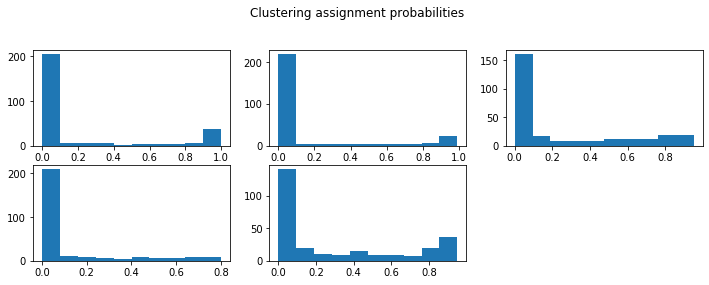

[0 1 2 3 4]


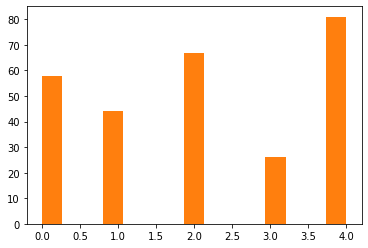

In [31]:
_, tmp_pi, tmp_m = model.predict_zbars_and_pis_m2(data_x)

tmp_pi = tmp_pi.reshape([-1, K])[tmp_m.reshape([-1]) == 1]

ncol = nrow = int(np.ceil(np.sqrt(K)))
plt.figure(figsize=[4*ncol, 2*nrow])
for k in range(K):
    plt.subplot(ncol, nrow, k+1)
    plt.hist(tmp_pi[:, k])
plt.suptitle("Clustering assignment probabilities")
plt.show()
# plt.savefig(save_path + 'results/figure_clustering_assignments.png')
plt.close()


# check selector outputs and intialized classes
#pred_y, tmp_m = model.predict_s_sample(tr_data_x)
pred_y, tmp_m = model.predict_s_sample(data_x)

pred_y = pred_y.reshape([-1, 1])[tmp_m.reshape([-1]) == 1]
print(np.unique(pred_y))

plt.hist(pred_y[:, 0], bins=15, color='C1', alpha=1.0)
plt.show()
# plt.savefig(save_path + 'results/figure_clustering_hist.png')
plt.close()

In [ ]:
counter = 0
for i in pred_y:
    if i[0] == 0:
        counter = counter + 1
counter

# Prepare Patient Cluster Information for Statistical Analysis

In [198]:
# Progressions by cluster for all 69 subjects
patientProgressions = np.array_split(pred_y, 69)
patientProgressions

[array([[2],
        [4],
        [0],
        [0]]),
 array([[2],
        [4],
        [2],
        [4]]),
 array([[2],
        [4],
        [4],
        [0]]),
 array([[2],
        [2],
        [4],
        [0]]),
 array([[2],
        [2],
        [4],
        [4]]),
 array([[2],
        [4],
        [0],
        [0]]),
 array([[3],
        [3],
        [2],
        [2]]),
 array([[1],
        [1],
        [1],
        [1]]),
 array([[4],
        [0],
        [0],
        [0]]),
 array([[4],
        [4],
        [0],
        [0]]),
 array([[3],
        [2],
        [2],
        [2]]),
 array([[4],
        [4],
        [0],
        [0]]),
 array([[1],
        [1],
        [1],
        [3]]),
 array([[1],
        [1],
        [1],
        [1]]),
 array([[3],
        [3],
        [3],
        [3]]),
 array([[2],
        [4],
        [4],
        [0]]),
 array([[4],
        [4],
        [0],
        [0]]),
 array([[2],
        [2],
        [4],
        [4]]),
 array([[2],
        [2],
  

In [102]:
# Save patient Progressions Matrix - Shows patient cluster at each visit, used for all analysis later
#np.save('PatientProgressions5clusters', patientProgressions)

In [11]:
patientProgressions = np.load('patientProgressions5clusters.npy')

In [12]:
# Real patient IDs, as found in demographics spreadsheet
patientIDs = np.load('4VisitPatientIDs.npy')
patientIDs

array([141,  48,  27,  66,  67,  50, 127, 134, 140, 126,  86,  53, 137,
       144,  54, 130,  20, 114, 112,  31,  77,  22, 149,  42,  69, 110,
        61,  43,  85,  18,  21,  34,  84,  73,  10,  90, 145, 131, 117,
        37, 116,  40, 143,  88, 119,  57,  33,  75, 128, 148, 136,  41,
        15, 133, 113, 135,  59, 111, 120,  76, 115, 125,  74,  87,  68,
       139, 129, 121,  72], dtype=int64)

In [13]:
patientProgressions

array([[[2],
        [4],
        [0],
        [0]],

       [[2],
        [4],
        [2],
        [4]],

       [[2],
        [4],
        [4],
        [0]],

       [[2],
        [2],
        [4],
        [0]],

       [[2],
        [2],
        [4],
        [4]],

       [[2],
        [4],
        [0],
        [0]],

       [[3],
        [3],
        [2],
        [2]],

       [[1],
        [1],
        [1],
        [1]],

       [[4],
        [0],
        [0],
        [0]],

       [[4],
        [4],
        [0],
        [0]],

       [[3],
        [2],
        [2],
        [2]],

       [[4],
        [4],
        [0],
        [0]],

       [[1],
        [1],
        [1],
        [3]],

       [[1],
        [1],
        [1],
        [1]],

       [[3],
        [3],
        [3],
        [3]],

       [[2],
        [4],
        [4],
        [0]],

       [[4],
        [4],
        [0],
        [0]],

       [[2],
        [2],
        [4],
        [4]],

       [[2],
        [2],
  

In [14]:
# Finding clinical label distribution for each cluster 
cortical_thickness = pd.read_csv('Cortical_Thickness.csv')
labels = []

for j in range(5):
    clusterLabel = []
    for i in range(len(patientProgressions)):
        for k in range(len(patientProgressions[i])):
            if patientProgressions[i][k] == j:
                patientID = patientIDs[i] 
                visCode = patientData4Visits[i][k][2]
                label = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["DX"].values[0]
                clusterLabel.append([label, patientID, visCode])
                
    labels.append(clusterLabel)

In [11]:
labels

[[['EMCI', 141, 36],
  ['EMCI', 141, 48],
  ['EMCI', 27, 36],
  ['EMCI', 66, 48],
  ['EMCI', 50, 12],
  ['EMCI', 50, 24],
  ['EMCI', 140, 3],
  ['AD', 140, 24],
  ['AD', 140, 36],
  ['AD', 126, 36],
  ['AD', 126, 48],
  ['EMCI', 53, 12],
  ['AD', 53, 48],
  ['AD', 130, 48],
  ['LMCI', 20, 24],
  ['LMCI', 20, 48],
  ['AD', 69, 24],
  ['EMCI', 110, 48],
  ['EMCI', 43, 6],
  ['EMCI', 43, 24],
  ['AD', 10, 3],
  ['AD', 10, 6],
  ['AD', 10, 12],
  ['EMCI', 145, 3],
  ['EMCI', 145, 6],
  ['EMCI', 145, 12],
  ['AD', 116, 6],
  ['AD', 116, 12],
  ['AD', 40, 24],
  ['AD', 119, 12],
  ['AD', 119, 24],
  ['LMCI', 57, 6],
  ['AD', 57, 12],
  ['AD', 57, 24],
  ['EMCI', 75, 36],
  ['CN', 148, 24],
  ['EMCI', 148, 48],
  ['EMCI', 133, 3],
  ['EMCI', 133, 24],
  ['EMCI', 133, 48],
  ['LMCI', 113, 12],
  ['LMCI', 113, 24],
  ['LMCI', 111, 24],
  ['LMCI', 111, 36],
  ['EMCI', 120, 3],
  ['EMCI', 120, 6],
  ['EMCI', 120, 12],
  ['EMCI', 76, 24],
  ['EMCI', 76, 36],
  ['LMCI', 115, 12],
  ['AD', 115, 24],

In [12]:
outputs,_ = model.predict_y_bars(data_x)

NameError: name 'model' is not defined

In [45]:
# Finding Output Score distribution for each cluster
predictedscores = []

for j in range(5):
    clusterScore = []
    for i in range(len(patientProgressions)):
        for k in range(len(patientProgressions[i])):
            if patientProgressions[i][k] == j:
                clusterScore.append(outputs[i][k])
             
    predictedscores.append(clusterScore)

NameError: name 'outputs' is not defined

In [57]:
# Finding Output Score distribution for each cluster
scores = []

for j in range(5):
    clusterScore = []
    for i in range(len(patientProgressions)):
        for k in range(len(patientProgressions[i])):
            if patientProgressions[i][k] == j:
                clusterScore.append(data_y[i][k])
             
    scores.append(clusterScore)

In [58]:
ptau = []
for i in scores:
    cluster = []
    for j in range(len(i)):
        cluster.append(i[j][0])
    ptau.append(cluster)
ptau

df = pd.DataFrame.from_records(ptau)
df = df.T
DT1 = df[0].dropna()
DT2 = df[1].dropna()
DT3 = df[2].dropna()
DT4 = df[3].dropna()
DT5 = df[4].dropna()
#DT6 = df[5].dropna()


In [59]:
list = [DT1, DT2, DT3, DT4, DT5]

from scipy import stats
pvalues = []

for i in range(0, 5):
    for j in range(0,5):
        if j > i:
            pvalues.append(stats.ttest_ind(list[i], list[j])[1])

pvalues

[5.538594553622861e-05,
 0.728887531205669,
 0.1470246746608252,
 0.6883525539066707,
 6.79184646484731e-06,
 0.06217180434667167,
 1.4431901554276013e-06,
 0.07680597173340174,
 0.9750766764084934,
 0.056803371594586524]

# Values

In [61]:
total = []
for i in range(len(scores[0])):
    visit = []
    for j in range(len(scores[0][i])):
        visit.append(scores[0][i][j])
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
#total = np.var(total, axis = 0)
total

array([0.411, 0.29 , 0.203, 0.193, 0.21 , 0.286, 0.276, 0.618, 0.418,
       0.354, 0.417, 0.447, 0.591, 0.476])

In [194]:
total = []
for i in range(len(scores[1])):
    visit = []
    for j in range(len(scores[1][i])):
        visit.append(scores[1][i][j])
    total.append(visit)

total = np.asarray(total)
#total = np.mean(total, axis = 0)
total = np.var(total, axis = 0)
total

array([0.043, 0.035, 0.03 , 0.023, 0.036, 0.047, 0.025, 0.051, 0.033,
       0.024, 0.035, 0.049, 0.051, 0.031])

In [195]:
total = []
for i in range(len(scores[2])):
    visit = []
    for j in range(len(scores[2][i])):
        visit.append(scores[2][i][j])
    total.append(visit)

total = np.asarray(total)
#total = np.mean(total, axis = 0)
total = np.var(total, axis = 0)
total

array([0.05 , 0.059, 0.034, 0.033, 0.04 , 0.061, 0.031, 0.082, 0.074,
       0.089, 0.077, 0.081, 0.086, 0.065])

In [91]:
total = []
for i in range(len(scores[3])):
    visit = []
    for j in range(len(scores[3][i])):
        visit.append(scores[3][i][j])
    total.append(visit)

total = np.asarray(total)
#total = np.mean(total, axis = 0)
total = np.var(total, axis = 0)
total

array([0.059, 0.055, 0.033, 0.019, 0.042, 0.047, 0.027, 0.058, 0.039,
       0.041, 0.052, 0.065, 0.086, 0.044])

In [92]:
total = []
for i in range(len(scores[4])):
    visit = []
    for j in range(len(scores[4][i])):
        visit.append(scores[4][i][j])
    total.append(visit)

total = np.asarray(total)
#total = np.mean(total, axis = 0)
total = np.var(total, axis = 0)
total

array([0.046, 0.079, 0.048, 0.038, 0.044, 0.056, 0.037, 0.058, 0.055,
       0.042, 0.04 , 0.081, 0.083, 0.041])

In [49]:
total = []
for i in range(len(scores[5])):
    visit = []
    for j in range(len(scores[5][i])):
        visit.append(scores[5][i][j])
    total.append(visit)

total = np.asarray(total)
#total = np.mean(total, axis = 0)
total = np.var(total, axis = 0)
total

array([0.04 , 0.063, 0.033, 0.039, 0.021, 0.064, 0.032, 0.076, 0.054,
       0.067, 0.086, 0.13 , 0.113, 0.06 ])

In [101]:
print(np.mean(scores[4], axis = 0))

[0.426 0.346 0.204 0.18  0.202 0.33  0.294 0.44  0.255 0.201 0.239 0.278
 0.407 0.304]


# Entropy

In [ ]:
total = []
for i in range(len(scores[0])):
    visit = []
    for j in range(len(scores[0][i])):
        visit.append((scores[0][i][j] - predictedscores[0][i][j])**2)
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
total

In [ ]:
total = []
for i in range(len(scores[1])):
    visit = []
    for j in range(len(scores[1][i])):
        visit.append((scores[1][i][j] - predictedscores[1][i][j])**2)
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
total

In [ ]:
total = []
for i in range(len(scores[2])):
    visit = []
    for j in range(len(scores[2][i])):
        visit.append((scores[2][i][j] - predictedscores[2][i][j])**2)
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
total

In [ ]:
total = []
for i in range(len(scores[3])):
    visit = []
    for j in range(len(scores[3][i])):
        visit.append((scores[3][i][j] - predictedscores[3][i][j])**2)
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
total

In [ ]:
total = []
for i in range(len(scores[4])):
    visit = []
    for j in range(len(scores[4][i])):
        visit.append((scores[4][i][j] - predictedscores[4][i][j])**2)
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
total

In [ ]:
total = []
for i in range(len(scores[5])):
    visit = []
    for j in range(len(scores[5][i])):
        visit.append((scores[5][i][j] - predictedscores[5][i][j])**2)
    total.append(visit)

total = np.asarray(total)
total = np.mean(total, axis = 0)
total

# Demographics Tests

In [82]:
# Cluster Age Calculation
clusterAges = []
for j in range(5):
    ages = []
    for i in (labels[j]):
        patientID = i[1]
        visCode = i[2]
        age = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["PTGENDER"].values[0] 
        ages.append(age)
    clusterAges.append(ages)

In [35]:
sum = 0
for i in range(5):
    sum += len(labels[i])
print(sum)

276


In [83]:
# Cluster Education Calculation
clusterAges = []
for j in range(5):
    counter0 = 0
    counter1 = 0
    counter2 = 0
    for i in (labels[j]):
        patientID = i[1]
        visCode = i[2]
        gender = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["PTGENDER"].values[0]
        if gender == 'Male':
            counter0 += 1
        elif gender == 'Female':
            counter1 += 1

    clusterAges.append(counter0)

In [84]:
clusterAges

[45, 17, 27, 14, 53]

In [ ]:
expectedMales = [56, 95, 29,49, 47]
expectedMales = [i * 0.12 for i in expectedMales]
expectedMales

In [ ]:
chisquare(clusterAges, f_exp=expectedMales)

In [ ]:
df = pd.DataFrame(clusterAges)
print(df.describe())

In [ ]:
averages = []
clusterAges = np.asarray(clusterAges)
for i in clusterAges:
    averages.append(np.mean(i, axis = 0))

In [72]:
df = pd.DataFrame.from_records(clusterAges)
df = df.T
DT1 = df[0].dropna()
DT2 = df[1].dropna()
DT3 = df[2].dropna()
DT4 = df[3].dropna()
DT5 = df[4].dropna()

In [73]:
print('Cluster 1\n')
print(DT1.describe())
print('Cluster 2\n')
print(DT2.describe())
print('Cluster 3\n')
print(DT3.describe())
print('Cluster 4\n')
print(DT4.describe())
print('Cluster 5\n')
print(DT5.describe())

Cluster 1

count    58.000000
mean     16.275862
std       2.858003
min      11.000000
25%      14.000000
50%      18.000000
75%      18.000000
max      20.000000
Name: 0, dtype: float64
Cluster 2

count    44.000000
mean     16.727273
std       2.275896
min      12.000000
25%      16.000000
50%      18.000000
75%      18.000000
max      20.000000
Name: 1, dtype: float64
Cluster 3

count    67.000000
mean     16.298507
std       2.480316
min      11.000000
25%      14.000000
50%      16.000000
75%      18.500000
max      20.000000
Name: 2, dtype: float64
Cluster 4

count    26.000000
mean     15.346154
std       2.637306
min      12.000000
25%      12.250000
50%      16.000000
75%      18.000000
max      19.000000
Name: 3, dtype: float64
Cluster 5

count    81.000000
mean     16.555556
std       2.876630
min      11.000000
25%      14.000000
50%      18.000000
75%      19.000000
max      20.000000
Name: 4, dtype: float64


In [ ]:
# Shapiro Wilks Normality Test

shapiro_test = stats.shapiro(DT1)
print(shapiro_test)
shapiro_test = stats.shapiro(DT2)
print(shapiro_test)
shapiro_test = stats.shapiro(DT3)
print(shapiro_test)
shapiro_test = stats.shapiro(DT4)
print(shapiro_test)
shapiro_test = stats.shapiro(DT5)
print(shapiro_test)

In [ ]:
# Levene variance test  
stats.levene(DT1, DT2, DT3, DT4, DT5)

In [38]:
# One way ANOVA

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(DT1, DT2, DT3, DT4, DT5)
print(fvalue, pvalue)

1.966420219687149 0.09989093091222039


In [74]:
# Kruskal Wallis
stats.kruskal(DT1, DT2, DT3, DT4, DT5)

KruskalResult(statistic=5.273257943663614, pvalue=0.26039076708882175)

In [40]:
# Dunn Test for Post Hoc
list1 = DT1.values.tolist()
list2 = DT2.values.tolist()
list3 = DT3.values.tolist()
list4 = DT4.values.tolist()
list5 = DT5.values.tolist()
list6 = []
list6.append(list1)
list6.append(list2)
list6.append(list3)
list6.append(list4)
list6.append(list5)

posthoc_dunn(list6, p_adjust = 'bonferroni')

,1,2,3,4,5
1,-1.000000,0.098496,0.070642,1.0,1.000000
2,0.098496,-1.000000,1.000000,1.0,0.550758
3,0.070642,1.000000,-1.000000,1.0,0.481137
4,1.000000,1.000000,1.000000,-1.0,1.000000
5,1.000000,0.550758,0.481137,1.0,-1.000000


# Clinical Test Score Analysis

In [63]:
biomarkers = pd.read_csv('logistic_ADNI12.csv')

clustersScores = []
for cluster in range(5): 
    clusterScores = []
    for j in range(len(labels[cluster])):
        time = labels[cluster][j][2]
        if (time == 0):
            patientScores = []
            patientIndex = labels[cluster][j][1]
            patientID = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientIndex) & (cortical_thickness["VISCODE"] == time)]["PTID"].values[0]
            RID = patientID[len(patientID) - 4:] 
            RID = int(RID)
            if (RID in biomarkers["RID"].values):
                patientScores.append(biomarkers.loc[(biomarkers["RID"] == RID)]["ABETA"].values[0])
                patientScores.append(biomarkers.loc[(biomarkers["RID"] == RID)]["TAU"].values[0])
                patientScores.append(biomarkers.loc[(biomarkers["RID"] == RID)]["PTAU"].values[0])
                patientScores = np.asarray(patientScores)
                clusterScores.append(patientScores)
    clusterScores = np.asarray(clusterScores)
    clustersScores.append(clusterScores)
            

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
clustersScores

In [ ]:
ptau = []
for i in clustersScores:
    cluster = []
    for j in range(len(i)):
        cluster.append(i[j][1])
    ptau.append(cluster)
ptau

df = pd.DataFrame.from_records(ptau)
df = df.T
DT1 = df[0].dropna()
DT2 = df[1].dropna()
DT3 = df[2].dropna()
DT4 = df[3].dropna()
DT5 = df[4].dropna()
DT6 = df[5].dropna()


print('Cluster 1\n')
print(DT1.describe())
print('Cluster 2\n')
print(DT2.describe())
print('Cluster 3\n')
print(DT3.describe())
print('Cluster 4\n')
print(DT4.describe())
print('Cluster 5\n')
print(DT5.describe())
print('Cluster 6\n')
print(DT6.describe())

# Kruskal Wallis
stats.kruskal(DT1, DT2, DT5, DT4, DT3)

In [ ]:
# Dunn Test for Post Hoc
list1 = DT1.values.tolist()
list2 = DT2.values.tolist()
list3 = DT3.values.tolist()
list4 = DT4.values.tolist()
list5 = DT5.values.tolist()
list6 = []
list6.append(list1)
list6.append(list2)
list6.append(list3)
list6.append(list4)
list6.append(list5)

posthoc_dunn(list6, p_adjust = 'bonferroni')

In [103]:
biomarkers = pd.read_csv('Longitudinal_Network_Demographic.csv')
biomarkers2 = pd.read_csv('data2.csv')
cortical_thickness = pd.read_csv('Cortical_Thickness.csv')

clustersScores = []
for cluster in range(5): 
    clusterScores = []
    for j in (labels[cluster]):
        patient = j[1]  
        visit = j[2]
        patientScores = []
        scanID = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patient) & (cortical_thickness["VISCODE"] == visit)]["SCANINDEX"].values[0]
        if (scanID in biomarkers["subject"].values):
            patientScores.append(biomarkers.loc[(biomarkers["subject"] == scanID)]["MMSE"].values[0])
            patientScores.append(biomarkers.loc[(biomarkers["subject"] == scanID)]["CDRSB"].values[0])
        if (scanID in biomarkers2["subject"].values):
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["ADAS11"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["ADAS13"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["ADASQ4"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["FDG"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["AV45"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["ABETA"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["TAU"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["PTAU"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["RAVLT_immediate"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["RAVLT_learning"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["RAVLT_forgetting"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["RAVLT_perc_forgetting"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["LDELTOTAL"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["DIGITSCOR"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["TRABSCOR"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["FAQ"].values[0])
            patientScores.append(biomarkers2.loc[biomarkers2["subject"] == scanID]["MOCA"].values[0])
            

        patientScores = np.asarray(patientScores)
        clusterScores.append(patientScores)
    clusterScores = np.asarray(clusterScores)
    clustersScores.append(clusterScores)

In [90]:
for i in range(5):
    print(np.nanmean(clustersScores[i], axis = 0))

[  1.28    1.212 653.967 403.69   39.036  27.212   2.75    4.66   76.896
   4.841     nan 139.12    8.68   21.12 ]
[1.310e+00 1.079e+00 1.056e+03 2.247e+02 2.025e+01 4.525e+01 5.556e+00
 3.028e+00 3.049e+01 1.309e+01       nan 8.169e+01 1.028e+00 2.542e+01]
[  1.283   1.227 823.845 308.031  29.777  38.32    4.3     4.36   55.334
   8.619     nan 101.551   3.06   22.96 ]
[1.327e+00 1.066e+00 1.072e+03 2.878e+02 2.490e+01 4.424e+01 5.353e+00
 4.353e+00 4.186e+01 1.100e+01       nan 8.859e+01 7.647e-01 2.412e+01]
[  1.234   1.216 767.257 272.754  26.144  33.621   3.862   5.293  67.679
   6.66      nan 112.315   4.169  22.328]


C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [88]:
clustersScores[0]

array([[ 3.000e+01,  3.000e+00,  7.000e+00,  1.000e+01,  3.000e+00,
               nan,        nan,        nan,        nan,        nan,
         3.300e+01,  0.000e+00,  3.000e+00,  5.000e+01,  8.000e+00,
               nan,  7.600e+01,        nan,  2.200e+01],
       [ 2.700e+01,        nan,  5.000e+00,  1.200e+01,  7.000e+00,
               nan,  1.027e+00,        nan,        nan,        nan,
         3.400e+01,  5.000e+00,  9.000e+00,  1.000e+02,  7.000e+00,
               nan,  7.300e+01,        nan,  2.500e+01],
       [ 2.800e+01,  2.000e+00,  5.000e+00,  8.000e+00,  3.000e+00,
               nan,        nan,        nan,        nan,        nan,
         3.700e+01,  2.000e+00,  6.000e+00,  8.571e+01,  1.000e+01,
               nan,  8.400e+01,  2.000e+00,  2.400e+01],
       [ 2.800e+01,  1.000e+00,  1.300e+01,  2.200e+01,  9.000e+00,
               nan,  1.165e+00,        nan,        nan,        nan,
         2.200e+01,  0.000e+00,  4.000e+00,  1.000e+02,  6.000e+00,
             

In [123]:
ptau = []
for i in clustersScores:
    cluster = []
    for j in range(len(i)):
        cluster.append(i[j][18])
    ptau.append(cluster)
ptau

df = pd.DataFrame.from_records(ptau)
df = df.T
DT1 = df[0].dropna()
DT2 = df[1].dropna()
DT3 = df[2].dropna()
DT4 = df[3].dropna()
DT5 = df[4].dropna()
#DT6 = df[5].dropna()

'''
print('Cluster 1\n')
print(DT1.describe())
print('Cluster 2\n')
print(DT2.describe())
print('Cluster 3\n')
print(DT3.describe())
print('Cluster 4\n')
print(DT4.describe())
print('Cluster 5\n')
print(DT5.describe())
print('Cluster 6\n')
print(DT6.describe())
dt = pd.concat([DT1,DT2, DT3, DT4, DT5, DT6], axis = 0)
print(dt.describe())

# Kruskal Wallis
stats.kruskal(DT5, DT2, DT6, DT3, DT4, DT1)
'''

list = [DT1, DT2, DT3, DT4, DT5]

from scipy import stats
pvalues = []

for i in range(0, 5):
    for j in range(0,5):
        if j > i:
            pvalues.append(stats.ttest_ind(list[i], list[j])[1])

pvalues

[6.508515996507414e-09,
 0.013249321605911645,
 0.0014432463424577386,
 0.07727475175409955,
 0.0008748604105536254,
 0.05448571898477219,
 9.960581970896168e-06,
 0.2387575107547369,
 0.37206908894236257,
 0.05120260406436358]

In [ ]:
# Dunn Test for Post Hoc
list1 = DT1.values.tolist()
list2 = DT2.values.tolist()
list3 = DT3.values.tolist()
list4 = DT4.values.tolist()
list5 = DT5.values.tolist()
list6 = DT6.values.tolist()
list7 = []
#list7.append(list1)
list7.append(list2)
list7.append(list3)
#list7.append(list4)
list7.append(list5)
list7.append(list6)

posthoc_dunn(list7, p_adjust = 'bonferroni')

# Supplemental Cluster Information

In [170]:
# Patient Transitions
for i in range(len(patientData4Visits)):
    list1 = patientData4Visits[i][0][1]
    list2 = patientData4Visits[i][1][1]
    list3 = patientData4Visits[i][2][1]
    list4 = patientData4Visits[i][3][1]
    
    if (list1 == [0,1,0] or list2 == [0,1,0] or list3 == [0,1,0]) and (list2 == [0,0,1] or list3 == [0,0,1] or list4 == [0,0,1]):
        print(patientIDs[i])

140
126
53
130
112
77
149
69
40
119
57
128
59
115


In [15]:
# Cluster label distributions
counter1 = 0
counter2 = 0
counter3 = 0
counter4 = 0
#cluster = 4

for cluster in range(5):
    for i in labels[cluster]:
        if i[0] == "CN" or i[0] == "SMC":
            counter1 += 1
        elif i[0] == "EMCI":
            counter2 += 1
        elif i[0] == "LMCI":
            counter2 += 1
        else:
            counter3 += 1
#total = len(labels[cluster])
#print(counter1/total)
#print(counter2/total)
#print(counter3/total)
#print(counter4/total)

In [20]:
counter2

152

In [ ]:
def is_subsequence(a, b):
    b_it = iter(b)
    try:
        for i in range(len(a)):
            while next(b_it) != a[i]:
                pass
    except StopIteration:
        return False
    else:
        return True

In [ ]:
# Finding number in each temporal subtype

subtype1 = [0,5,9,3,7,1,8,4]
subtype2 = [0,9,3,5,7,1,8,4]
subtype4 = [0,6,4,7,2]

counter1 = 0
counter2 = 0
counter3 = 0
counter4 = 0

for i in range(len(patientProgressions)):
    indexes = np.unique(patientProgressions[i], return_index=True)[1]
    new = [patientProgressions[i][index] for index in sorted(indexes)]
    new = np.concatenate(new)
    
    #if np.any(patientProgressions[i] == j):
    if is_subsequence(new, subtype2) and is_subsequence(new, subtype1) :
        counter1 += 1
            


# Adjacency Matrix Analysis

In [13]:
# Load adjacency Matrices
# Generate average adjacency matrix=
cortical_thickness = pd.read_csv('Cortical_Thickness.csv')
clusters = []


for cluster in range(5):
    scanIDs = []
    clusterMatrices = []
    for i in range(len(patientProgressions)):
        for j in range(4):
            if patientProgressions[i][j][0] == cluster:
                patientID = patientIDs[i]
                visCode = patientData4Visits[i][j][2]
                scanID = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["SCANINDEX"].values[0]
                scanIDs.append(scanID)

    matrices = []
    for filename in os.listdir("C:/Users/andre/Desktop/RCompSci/Graph Code/Connectivity Data Implementation/Network-Data"):
        newName = filename.split("_",1)[0]     
        if newName in scanIDs:
            adjacencyMatrix = np.loadtxt("C:/Users/andre/Desktop/RCompSci/Graph Code/Connectivity Data Implementation/Network-Data/" + filename, dtype = 'int')
            adjacencyMatrix = adjacencyMatrix/adjacencyMatrix.max()
            matrices.append(adjacencyMatrix)
    clusters.append(matrices)

In [105]:
# Performing significance tests on specific edge weights - (computationally expensive - 148*148 = 21904 computations)
significantNodes = []
pvalues = []

for i in range(148):
    for j in range(148):
        clustersList = []
        for k in range(5):
            clusterList = []
            for m in range(len(clusters[k])):
                clusterList.append(clusters[k][m][i][j])
            clustersList.append(clusterList)
        


        #Significance Tests
        df = pd.DataFrame(clustersList)
        df = df.T
        DT1 = df[0].dropna()
        DT2 = df[1].dropna()
        DT3 = df[2].dropna()
        DT4 = df[3].dropna()
        DT5 = df[4].dropna()
        #DT6 = df[5].dropna()
        

        # Kruskal Wallis
        if not i == j and stats.f_oneway(DT1, DT2, DT3, DT4, DT5)[1] < 0.01:
            significantNodes.append([i + 1, j + 1])
            pvalues.append(round(stats.f_oneway(DT1, DT2, DT3, DT4, DT5)[1], 4))


In [106]:
len(significantNodes)

1742

In [110]:
#dunnTests = []
tTests = []

for pair in significantNodes:   
    i = pair[0] - 1
    j = pair[1] - 1
    clustersList = []
    for k in range(5):
        clusterList = []
        for m in range(len(clusters[k])):
            clusterList.append(clusters[k][m][i][j])
        clustersList.append(clusterList)


    #Significance Tests
    df = pd.DataFrame(clustersList)
    df = df.T
    DT1 = df[0].dropna()
    DT2 = df[1].dropna()
    DT3 = df[2].dropna()
    DT4 = df[3].dropna()
    DT5 = df[4].dropna()
   # DT6 = df[5].dropna()

    # Dunn Test for Post Hoc
    list1 = DT1.values.tolist()
    list2 = DT2.values.tolist()
    list3 = DT3.values.tolist()
    list4 = DT4.values.tolist()
    list5 = DT5.values.tolist()
    #list6 = DT6.values.tolist()
    list6 = []

    list6.append(list1)
    list6.append(list2)
    list6.append(list3)
    list6.append(list4)
    list6.append(list5)

    #dunnTests.append(posthoc_dunn(list6, p_adjust = 'bonferroni'))
    
    for a in range(len(list6)):
        for b in range(len(list6)):
            if b > a:
                pvalue = stats.ttest_ind(list6[a], list6[b])[1]
                if pvalue < 0.01:
                    tTests.append([a + 1, b + 1, i, j, pvalue])

In [112]:
np.save('ttests', tTests)

In [14]:
tTests = np.load('ttests.npy')

In [36]:
tTests

array([[1.00000000e+00, 2.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        2.86649681e-03],
       [2.00000000e+00, 5.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        5.88885395e-03],
       [1.00000000e+00, 2.00000000e+00, 0.00000000e+00, 4.00000000e+00,
        7.34839898e-04],
       ...,
       [1.00000000e+00, 2.00000000e+00, 1.47000000e+02, 1.45000000e+02,
        5.75807141e-05],
       [1.00000000e+00, 3.00000000e+00, 1.47000000e+02, 1.45000000e+02,
        8.57802933e-04],
       [1.00000000e+00, 4.00000000e+00, 1.47000000e+02, 1.45000000e+02,
        2.84981056e-03]])

In [50]:
#1,2 2,3 2,4 2,5
clusters12 = []
clusters23 = []
clusters24 = []
clusters25 = []
clusters35 = []
clusters34 = []
clusters45 = []

for i in tTests:
    if i[0] == 1 and i[1] == 2:
        clusters12.append(i[4])
        
    elif i[0] == 2 and i[1] == 3:
        clusters23.append(i[4])
        
    elif i[0] == 2 and i[1] == 4: 
        clusters24.append([i[2]+1,i[3]+1,i[4]])
    
    elif i[0] == 2 and i[1] == 5:
        clusters25.append([i[2]+1,i[3]+1])
        
    elif i[0] == 3 and i[1] == 5:
        clusters35.append([i[2] + 1,i[3] + 1,i[4]])
        
    elif i[0] == 3 and i[1] == 4:
        clusters34.append(i[4])
        
    elif i[0] == 4 and i[1] == 5:
        clusters45.append([int(i[2]) + 1,int(i[3]) + 1])
        

In [51]:
clusters45

[[1, 92],
 [2, 88],
 [2, 114],
 [2, 123],
 [2, 126],
 [3, 4],
 [3, 88],
 [4, 100],
 [4, 114],
 [4, 123],
 [7, 29],
 [7, 71],
 [7, 123],
 [7, 128],
 [8, 114],
 [9, 8],
 [9, 37],
 [9, 104],
 [9, 123],
 [10, 20],
 [10, 116],
 [11, 27],
 [11, 88],
 [11, 112],
 [11, 114],
 [11, 123],
 [11, 125],
 [11, 126],
 [11, 136],
 [11, 146],
 [14, 37],
 [14, 50],
 [15, 90],
 [15, 123],
 [16, 90],
 [16, 123],
 [17, 41],
 [17, 77],
 [18, 3],
 [18, 19],
 [18, 28],
 [18, 38],
 [18, 76],
 [18, 77],
 [18, 80],
 [19, 6],
 [19, 57],
 [19, 80],
 [19, 88],
 [19, 94],
 [19, 114],
 [19, 123],
 [19, 126],
 [19, 132],
 [19, 135],
 [20, 6],
 [20, 62],
 [20, 78],
 [20, 88],
 [20, 92],
 [20, 97],
 [20, 112],
 [20, 114],
 [20, 123],
 [20, 125],
 [20, 126],
 [20, 136],
 [20, 145],
 [21, 17],
 [21, 64],
 [22, 30],
 [23, 34],
 [24, 19],
 [24, 78],
 [24, 92],
 [25, 111],
 [25, 123],
 [25, 126],
 [26, 114],
 [26, 123],
 [27, 11],
 [27, 37],
 [27, 62],
 [27, 88],
 [27, 114],
 [27, 123],
 [27, 126],
 [28, 123],
 [28, 126],
 [

In [ ]:
np.save('AdjComparison',dunnTests)

In [164]:
pairs = []
cluster12 = []
cluster13 = []
cluster14 = []
cluster15 = []
cluster16 = []
cluster23 = []
cluster232 = []
cluster24 = []
cluster242 = []
cluster25 = []
cluster252 = []
cluster26 = []
cluster262 = []
cluster34 = []
cluster35 = []
cluster36 = []
cluster45 = []
cluster46 = []
cluster56 = []

for i in range(len(dunnTests)):
    if (dunnTests[i].iloc[0,1] < 0.01):
        cluster12.append([significantNodes[i],dunnTests[i].iloc[0,1]])
    #if (dunnTests[i].iloc[0,2] < 0.01):
     #   cluster13.append(significantNodes[i])
    #if (dunnTests[i].iloc[0,3] < 0.01):
    #    cluster14.append(significantNodes[i])
   # if (dunnTests[i].iloc[0,4] < 0.01):
    #    cluster15.append(significantNodes[i])
    #if (dunnTests[i].iloc[0,5] < 0.01):
     #   cluster16.append(significantNodes[i])
    if (dunnTests[i].iloc[1,2] < 0.01):
        cluster23.append([significantNodes[i],dunnTests[i].iloc[1,2]])
        cluster232.append(dunnTests[i].iloc[1,2])
    if (dunnTests[i].iloc[1,3] < 0.01):
        cluster24.append(significantNodes[i])
        cluster242.append(dunnTests[i].iloc[1,3])
    if (dunnTests[i].iloc[1,4] < 0.01):
        cluster25.append([significantNodes[i],dunnTests[i].iloc[1,4]])
        cluster252.append(dunnTests[i].iloc[1,4])
    if (dunnTests[i].iloc[1,5] < 0.01):
        cluster26.append(significantNodes[i])
        cluster262.append(dunnTests[i].iloc[1,5])
'''
    if (dunnTests[i].iloc[2,3] < 0.01):
        cluster34.append(significantNodes[i])
    if (dunnTests[i].iloc[2,4] < 0.01):
        cluster35.append(significantNodes[i])
    if (dunnTests[i].iloc[2,5] < 0.01):
        cluster36.append(significantNodes[i])
    if (dunnTests[i].iloc[3,4] < 0.01):
        cluster45.append(significantNodes[i])
    if (dunnTests[i].iloc[3,5] < 0.01):
        cluster46.append(significantNodes[i])
    if (dunnTests[i].iloc[4,5] < 0.01):
        cluster56.append(significantNodes[i])
        
        
pairs.append(cluster12)
pairs.append(cluster13)
pairs.append(cluster14)
pairs.append(cluster15)
pairs.append(cluster23)
pairs.append(cluster24)
pairs.append(cluster25)
pairs.append(cluster34)
pairs.append(cluster35)
pairs.append(cluster45)
'''

'\n    if (dunnTests[i].iloc[2,3] < 0.01):\n        cluster34.append(significantNodes[i])\n    if (dunnTests[i].iloc[2,4] < 0.01):\n        cluster35.append(significantNodes[i])\n    if (dunnTests[i].iloc[2,5] < 0.01):\n        cluster36.append(significantNodes[i])\n    if (dunnTests[i].iloc[3,4] < 0.01):\n        cluster45.append(significantNodes[i])\n    if (dunnTests[i].iloc[3,5] < 0.01):\n        cluster46.append(significantNodes[i])\n    if (dunnTests[i].iloc[4,5] < 0.01):\n        cluster56.append(significantNodes[i])\n        \n        \npairs.append(cluster12)\npairs.append(cluster13)\npairs.append(cluster14)\npairs.append(cluster15)\npairs.append(cluster23)\npairs.append(cluster24)\npairs.append(cluster25)\npairs.append(cluster34)\npairs.append(cluster35)\npairs.append(cluster45)\n'

In [45]:
pairs = []
pairs.append(clusters12)
pairs.append(clusters23)
pairs.append(clusters24)
pairs.append(clusters25)
pairs.append(clusters35)
pairs.append(clusters34)
pairs.append(clusters45)

In [46]:
adjacency = np.zeros([148,148])
for triplet in pairs[6]:
    i = int(triplet[0] - 1)
    j = int(triplet[1] - 1)
    adjacency[i][j] = 1/triplet[2]

In [33]:
adjacency[126][78] = 0

In [47]:
np.savetxt('clusters45.txt', adjacency)

# Graph Theory Analysis

In [ ]:
# Generate average adjacency matrix=
cortical_thickness = pd.read_csv('Cortical_Thickness.csv')
clusters = []


for cluster in range(5):
    scanIDs = []
    clusterMatrices = []
    for i in range(len(patientProgressions)):
        for j in range(4):
            if patientProgressions[i][j][0] == cluster:
                patientID = patientIDs[i]
                visCode = patientData4Visits[i][j][2]
                scanID = cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["SCANINDEX"].values[0]
                scanIDs.append(scanID)

    matrices = []
    for filename in os.listdir("C:/Users/andre/Desktop/RCompSci/Graph Code/Connectivity Data Implementation/Network-Data"):
        newName = filename.split("_",1)[0]     
        if newName in scanIDs:
            adjacencyMatrix = np.loadtxt("C:/Users/andre/Desktop/RCompSci/Graph Code/Connectivity Data Implementation/Network-Data/" + filename, dtype = 'int')
            adjacencyMatrix = adjacencyMatrix/adjacencyMatrix.max()
            networkxGraph = nx.from_numpy_matrix(adjacencyMatrix, parallel_edges=False, create_using=nx.DiGraph)
            #for i in range(148):
                #matrices.append(networkxGraph.degree(i, 'weight'))
            centrality = nx.algorithms.centrality.load_centrality(networkxGraph, weight = "weight")
            matrices.append(centrality)
            #clusterMatrices.append(matrices)
    clusters.append(matrices)

    

In [ ]:
clusters1 = []
for i in clusters:
    clusterList = []
    for j in i:
        clusterList.append(list(j.values()))
    clusters1.append(clusterList)

In [ ]:
clusters1[0][0][0]

In [ ]:
significantNodes = []
pvalues = []
for node in range(148):
    nodeInDegree = []

    for i in clusters1:
        clusterDegree = []
        for j in i:
            clusterDegree.append(j[node])
        nodeInDegree.append(clusterDegree)


    #Significance Tests
    df = pd.DataFrame(nodeInDegree)
    df = df.T
    DT1 = df[0].dropna()
    DT2 = df[1].dropna()
    DT3 = df[2].dropna()
    DT4 = df[3].dropna()
    DT5 = df[4].dropna()

    '''
    print('Cluster 1\n')
    print(DT1.describe())
    print('Cluster 2\n')
    print(DT2.describe())
    print('Cluster 3\n')
    print(DT3.describe())
    print('Cluster 4\n')
    print(DT4.describe())
    print('Cluster 5\n')
    print(DT5.describe())
    '''


    # Kruskal Wallis
    if stats.kruskal(DT1, DT2, DT3, DT4, DT5)[1] < 0.03:
        significantNodes.append(node + 1)
        pvalues.append(round(stats.kruskal(DT1, DT2, DT3, DT4, DT5)[1], 4))

In [ ]:
pvalues

In [ ]:
# Find cluster thickness medians
nodeMedians = []
for node in significantNodes:
    clusterMedians = []
    for i in clusters1:
        clusterThicknesses = []
        for j in i:
            clusterThicknesses.append(j[node])
        #median = statistics.median(clusterThicknesses)
        median = statistics.mean(clusterThicknesses)
        clusterMedians.append(median)
    nodeMedians.append(clusterMedians)
        

In [ ]:
df = pd.DataFrame.from_records(nodeMedians)
df = df.T

columns = []
for i in range(len(nodeMedians)):
    columns.append(significantNodes[i])
df.columns = columns

classes = []
for i in range(5):
    classes.append(i)
#df = df.iloc[:, :30]    
df['Classes'] = classes
df = df.sort_values(by=3, axis=1)
df

fig, ax = plt.subplots(figsize=(20, 15))

pd.plotting.parallel_coordinates(
    df, ax = ax, class_column = 'Classes', color = ['red', 'blue', 'green', 'purple', 'yellow'],  axvlines=False)

In [ ]:
len(significantNodes)

In [ ]:
#Calculating In-Degree, Out-Degree, and Degree for nodes

networkxGraphs = []

for i in clusters:
    networkxGraph = nx.from_numpy_matrix(i, parallel_edges=False, create_using=nx.DiGraph)
    networkxGraphs.append(networkxGraph)

In [ ]:
inDegreeVectors = []

for i in range(5):
    clusterVector = []
    for j in range(148):
        clusterVector.append(networkxGraphs[i].in_degree(j, 'weight'))
    inDegreeVectors.append(clusterVector)

inDegreeVectors = np.asarray(inDegreeVectors)
inDegreeVectors

#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(10, 10)) # in inches
plt.imshow(inDegreeVectors,
              cmap="afmhot",
              interpolation="none")
plt.show()


In [ ]:
outDegreeVectors = []

for i in range(10):
    clusterVector = []
    for j in range(148):
        clusterVector.append(networkxGraphs[i].out_degree(j, 'weight'))
    outDegreeVectors.append(clusterVector)

outDegreeVectors = np.asarray(outDegreeVectors)
outDegreeVectors

#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(10, 10)) # in inches
plt.imshow(outDegreeVectors,
              cmap="afmhot",
              interpolation="none")
plt.show()


In [ ]:
degreeVectors = []

for i in range(10):
    clusterVector = []
    for j in range(148):
        clusterVector.append(networkxGraphs[i].degree(j, 'weight'))
    degreeVectors.append(clusterVector)

degreeVectors = np.asarray(degreeVectors)
degreeVectors

#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(10, 10)) # in inches
plt.imshow(degreeVectors,
              cmap="afmhot",
              interpolation="none")
plt.show()


In [ ]:
betweenness = []

for i in range(5):
    centrality = nx.algorithms.centrality.betweenness_centrality(networkxGraphs[i], k = 148, weight = "weight")
    betweenness.append(list(centrality.values()))


betweenness = np.asarray(betweenness)


#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(10, 10)) # in inches
plt.imshow(betweenness,
              cmap="afmhot",
              interpolation="none")
plt.show()


In [ ]:
eigenvectors = []

for i in range(10):
    centrality = nx.algorithms.centrality.eigenvector_centrality(networkxGraphs[i], max_iter = 200, weight = "weight")
    eigenvectors.append(list(centrality.values()))


eigenvectors = np.asarray(eigenvectors)


#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(10, 10)) # in inches
plt.imshow(eigenvectors,
              cmap="afmhot",
              interpolation="none")
plt.show()



In [ ]:
loads = []

for i in range(10):
    centrality = nx.algorithms.centrality.load_centrality(networkxGraphs[i], weight = "weight")
    loads.append(list(centrality.values()))


loads = np.asarray(loads)


#Plot adjacency matrix in toned-down black and white
fig = plt.figure(figsize=(10, 10)) # in inches
plt.imshow(loads,
              cmap="afmhot",
              interpolation="none")
plt.show()



In [ ]:
clusterCoefficients = []

for i in range(10):
    centrality = nx.algorithms.cluster.average_clustering(networkxGraphs[i], weight = "weight")
    clusterCoefficients.append(centrality)


clusterCoefficients = np.asarray(clusterCoefficients)


In [ ]:
clusterCoefficients
#np.save("Cluster Coefficients", clusterCoefficients)

# Cortical Thickness Analysis

In [124]:
# Array of all cortical thickness vectors, indexed by cluster
clusters2 = []

for cluster in range(5):
    thicknesses = []
    matrices = []
    for i in range(len(patientProgressions)):
        for j in range(4):
            thickness = []
            if patientProgressions[i][j] == cluster:
                patientID = patientIDs[i]
                visCode = patientData4Visits[i][j][2]
                for k in range(148):
                    thickness.append(cortical_thickness.loc[(cortical_thickness["PTINDEX"] == patientID) & (cortical_thickness["VISCODE"] == visCode)]["Node " + str(k+1)].values[0])
                thickness = thickness/max(thickness)
                thicknesses.append(thickness)
    thicknesses = np.asarray(thicknesses)
    clusters2.append(thicknesses)

In [163]:
# Creating thickness distributions for node n for each cluster

significantNodes = []
pvalues = [] 
for node in range(148):
    nodeThickness = []

    for i in clusters2:
        clusterThickness = []
        for j in i:
            clusterThickness.append(j[node])
        nodeThickness.append(clusterThickness)


    #Significance Tests
    df = pd.DataFrame(nodeThickness)
    df = df.T
    DT1 = df[0].dropna()
    DT2 = df[1].dropna()
    DT3 = df[2].dropna()
    DT4 = df[3].dropna()
    DT5 = df[4].dropna()
   # DT6 = df[5].dropna()

    '''
    print('Cluster 1\n')
    print(DT1.describe())
    print('Cluster 2\n')
    print(DT2.describe())
    print('Cluster 3\n')
    print(DT3.describe())
    print('Cluster 4\n')
    print(DT4.describe())
    print('Cluster 5\n')
    print(DT5.describe())
    '''

    
    # Kruskal Wallis
    if stats.kruskal(DT1, DT2, DT3, DT4, DT5)[1] < 0.01:
        list = [DT1, DT2, DT3, DT4, DT5]
        nodePvalues = []
        for i in range(0, 5):
            for j in range(0,5):
                if j > i:
                    nodePvalues.append(stats.ttest_ind(list[i], list[j])[1])
        pvalues.append(nodePvalues)
        significantNodes.append(node)

In [164]:
pvalues

[[0.09896305903647096,
  0.7197484676793588,
  0.41308627410172793,
  0.416829803744189,
  0.027584213624923266,
  0.45114230413624934,
  0.0044496429380729,
  0.20911445309849896,
  0.6437477233414213,
  0.0767350212394323],
 [6.061769214888627e-09,
  0.0004318088202506743,
  0.012460659347688408,
  0.0009650606150386762,
  0.00102534682862584,
  0.005393140051372986,
  0.0003622868298220194,
  0.9013049468106438,
  0.7235381582662461,
  0.8932755407196604],
 [6.032682616919327e-06,
  0.01260713591447889,
  0.17337706337823716,
  0.007497853408909776,
  0.006401113227049947,
  0.03761184533599799,
  0.009633528995016917,
  0.7657929599529179,
  0.8905380168351582,
  0.696655038586609],
 [7.290992742616133e-08,
  0.06418741826784269,
  0.004152960083232785,
  0.009735021797127512,
  3.433232079643459e-05,
  0.06967068785345008,
  0.0005040584797491401,
  0.10351283323971992,
  0.43881824279369486,
  0.2940424572461867],
 [0.00030255448726079374,
  0.015792463620762497,
  0.000431226899

In [188]:
for i in range(len(significantNodes)):
    significantNodes[i] = significantNodes[i] + 1

In [198]:
significantNodes

[23,
 35,
 37,
 38,
 43,
 47,
 55,
 60,
 61,
 76,
 91,
 97,
 108,
 109,
 112,
 117,
 122,
 124,
 134,
 135,
 146,
 148]

In [202]:
# Find cluster thickness medians
nodeMedians = []
for node in significantNodes:
    clusterMedians = []
    for i in clusters2:
        clusterThicknesses = []
        for j in i:
            clusterThicknesses.append(j[node - 1])
        #median = statistics.median(clusterThicknesses)
        mean = statistics.mean(clusterThicknesses)
        clusterMedians.append(mean)
    #clusterMedians = [float(k)/max(clusterMedians) for k in clusterMedians]
    nodeMedians.append(clusterMedians)
        


df = pd.DataFrame.from_records(nodeMedians)
df = df.T

columns = []
for i in range(len(nodeMedians)):
    columns.append(significantNodes[i])
df.columns = columns

classes = []
for i in range(5):
    classes.append(i)
df = df.iloc[:, :26]    
df['Classes'] = classes
df

,23,35,37,38,43,47,55,60,61,76,...,109,112,117,122,124,134,135,146,148,Classes
0,0.779291,0.802178,0.724189,0.744938,0.842317,0.693945,0.504724,0.603368,0.566668,0.584731,...,0.741100,0.734348,0.840515,0.642958,0.640323,0.562535,0.546013,0.555408,0.497408,0
1,0.895322,0.896600,0.791215,0.788024,0.909551,0.752168,0.581676,0.651425,0.618876,0.635433,...,0.868174,0.785622,0.905751,0.710029,0.704603,0.635475,0.595258,0.632848,0.571515,1
2,0.840662,0.848574,0.744425,0.772461,0.865677,0.712447,0.536614,0.642120,0.588470,0.629355,...,0.788830,0.752179,0.880283,0.674745,0.654871,0.613431,0.591748,0.608988,0.579313,2
3,0.838128,0.841090,0.766708,0.796825,0.877268,0.716600,0.547959,0.642985,0.580024,0.612279,...,0.836731,0.766015,0.921686,0.682639,0.663038,0.617855,0.576925,0.609908,0.567538,3
4,0.835344,0.850781,0.752184,0.766175,0.870311,0.703680,0.528359,0.631066,0.592860,0.601308,...,0.789689,0.762684,0.875105,0.674288,0.660564,0.588594,0.578166,0.588313,0.563810,4


In [180]:
for i in df.columns:
    df.loc[:,i] = 6 - df.loc[:,i].rank()

In [203]:
df.to_excel('thicknessMeans.xlsx')

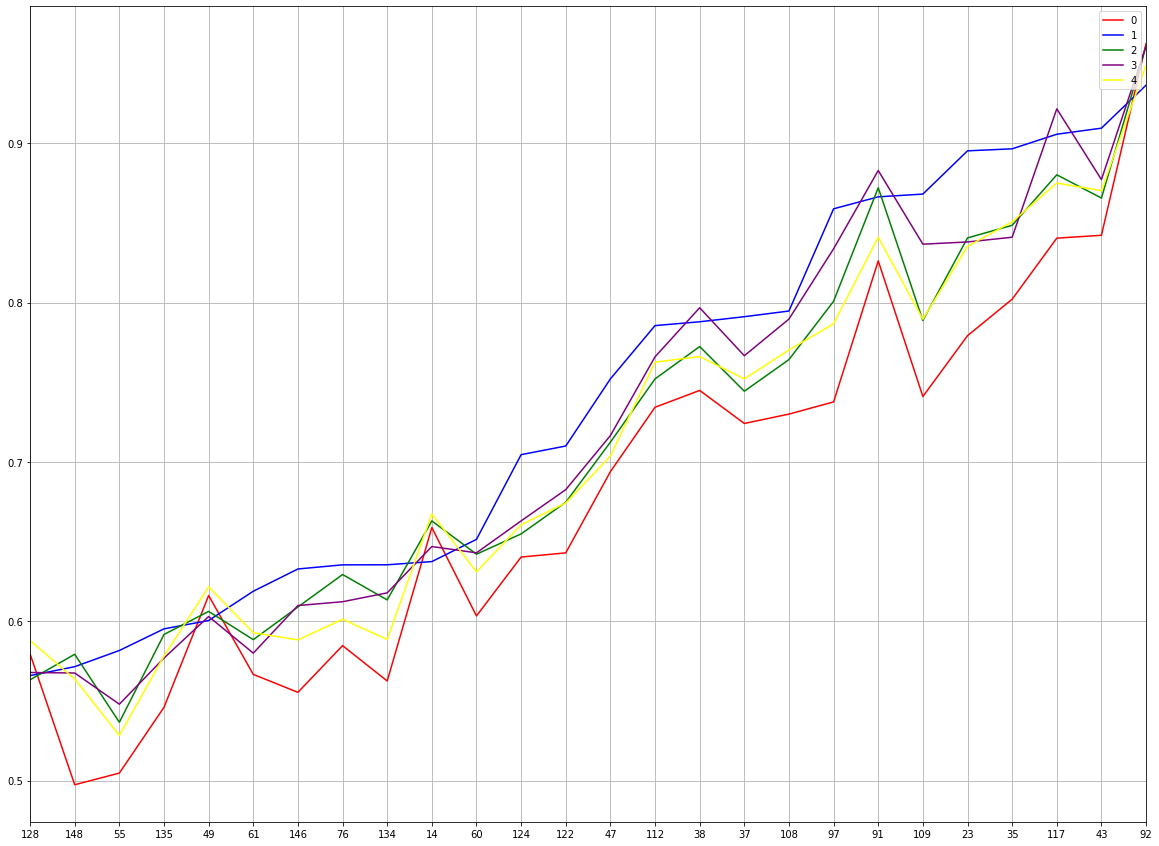

In [161]:
fig, ax = plt.subplots(figsize=(20, 15))

pd.plotting.parallel_coordinates(
    df, ax = ax, class_column = 'Classes', color = ['red', 'blue', 'green', 'purple', 'yellow'],  axvlines=False)

In [ ]:
# Shapiro Wilks Normality Test

shapiro_test = stats.shapiro(DT1)
print(shapiro_test)
shapiro_test = stats.shapiro(DT2)
print(shapiro_test)
shapiro_test = stats.shapiro(DT3)
print(shapiro_test)
shapiro_test = stats.shapiro(DT4)
print(shapiro_test)
shapiro_test = stats.shapiro(DT5)
print(shapiro_test)

# Levene variance test  
stats.levene(DT1, DT2, DT3, DT4, DT5)

# One way ANOVA

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(DT1, DT2, DT3, DT4, DT5)
print(fvalue, pvalue)

# Cluster Algorithm Evaluation + TSNE

In [ ]:
tmp_y, tmp_m = model.predict_y_bars(te_data_x)


y_pred = tmp_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]
y_true = te_data_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]


AUROC = np.zeros([y_dim])
AUPRC = np.zeros([y_dim])
for y_idx in range(y_dim):
    auroc, auprc = f_get_prediction_scores(y_true[:, y_idx], y_pred[:, y_idx])
    AUROC[y_idx] = auroc
    AUPRC[y_idx] = auprc

print('AUROC: {}'.format(AUROC))
print('AUPRC: {}'.format(AUPRC))

pred_y, tmp_m = model.predict_s_sample(te_data_x)

pred_y = (pred_y * tmp_m).reshape([-1, 1])
pred_y = pred_y[(tmp_m.reshape([-1, 1]) == 1)[:, 0], 0]

true_y = (te_data_y * np.tile(np.expand_dims(tmp_m, axis=2), [1,1,y_dim])).reshape([-1, y_dim])
true_y = true_y[(tmp_m.reshape([-1]) == 1)]
true_y = np.argmax(true_y, axis=1)

tmp_nmi    = normalized_mutual_info_score(true_y, pred_y)
tmp_ri     = adjusted_rand_score(true_y, pred_y)
tmp_purity = purity_score(true_y, pred_y)

print('NMI:{:.4f}, RI:{:.4f}, PURITY:{:.4f}'.format(tmp_nmi, tmp_ri, tmp_purity))

In [ ]:
AUPRC.mean()

In [ ]:
pred_y

In [ ]:
zbars, pis, _ = model.predict_zbars_and_pis_m2(data_x)

In [ ]:
pis

In [ ]:
zbars = np.asarray(zbars)

In [ ]:
zbars = zbars.reshape([4*69, 30])

In [ ]:
#T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(zbars)
plt.scatter(tsne_results[:,0], tsne_results[:,1], cmap = 'rainbow')

In [ ]:
counter = 0
for i in pis:
    for j in i:
        if max(j) > 0.9:
            counter = counter +1
counter

In [ ]:
np.load('AdjComparison.npy')